# Initialization

NFL season is upon us so let's engage in the time honored ritual of futilely trying to predict games that a coin flip would do a better job at predicting. 

In this post we will:
* munge our NFL data
* deploy a logistic regression for prediction
* use shrinking, scaling, hyperparameter tuning, and cross validation to improve our model

The logistic regression will be used to predict the binary classifier `home_win`. This model will be overly simplistic and is really just a proof of concept that we can successfully access, manipulate, and usefully deploy the data from `nfldb`. Later posts will posit more sophisticated models.

If you are not familiar with logistic regression, just know that it is a modified version of linear regression designed for binary independent variables. In this case, our independent variable will be `home_win` and our dependent variables differences between rolling team statistics over a five week period.

If you need help getting started with NFLDB, PostgreSQL, and Python, please see my other post [Getting started with NFLDB, PostgreSQL, and Python](http://timothykylethomas.me/nfldb-postgresql.html).

Ok, first thing we need to do is import our libraries and connect to PostgreSQL.

In [17]:
#there are some deprecation warnings that we don't want to print
import warnings
warnings.filterwarnings('ignore')

# import pandas and numpy for 
import pandas as pd
import numpy as np

# connect to PostgreSQL
import psycopg2
conn=psycopg2.connect("dbname='nfldb' user='kthomas1' host='localhost' password='' port=5432")

# Game Results

Interestingly, there is no `win` variable in `nfldb`, so out first order of business is to create the variable `home_win`. We will also create a variable `away_win` and `tie` in case we find those useful later. Note that the way we generate the `home_win` variable is through a list comprehension. For those of you new to Python, this is one of the most useful features of Python.

In [18]:
# query game results
game_results=pd.read_sql("""select season_year, week, home_team, home_score, away_team, away_score
from game
where season_type='Regular'""",con=conn)

# replace la with stl
game_results.replace(to_replace='LA', value='STL', inplace=True)

# compute wins and ties
game_results['home_win'] = [1 if x>y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]
game_results['away_win'] = [1 if x<y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]
game_results['tie'] = [1 if x==y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]

# sort the dataframe
game_results=game_results.sort_values(by=['season_year','home_team','week'])

# rename the year
game_results=game_results.rename(columns = {'season_year':'year'})

# print first 10 entries
game_results.head(10)

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie
864,2009,1,ARI,16,SF,20,0,1,0
153,2009,3,ARI,10,IND,31,0,1,0
250,2009,5,ARI,28,HOU,21,1,0,0
727,2009,8,ARI,21,CAR,34,0,1,0
281,2009,10,ARI,31,SEA,20,1,0,0
829,2009,13,ARI,30,MIN,17,1,0,0
917,2009,16,ARI,31,STL,10,1,0,0
361,2009,17,ARI,7,GB,33,0,1,0
860,2009,1,ATL,19,MIA,7,1,0,0
1115,2009,2,ATL,28,CAR,20,1,0,0


I doubled checked a few of these and the data looks good. As a baseline for our predictive model, we will use the simple algorithm of always picking the home team to win.

In [3]:
# total number of games
total_games = len(game_results)

# total number of home wins
home_wins = game_results.home_win.sum()

# total home wins/total number of games
home_win_rate = home_wins/total_games

print("Home Team Win Rate: {:.2f}% ".format(home_win_rate*100))

Home Team Win Rate: 56.25% 


# Stats

Now we need to process the statistics that will act as our dependent variables in the logistic regression. Broadly, this process will have the following steps:

1. Query the database of statistics
2. Encode points and turnovers
3. Split into Defensive and Offensive Statistics
4. Compute lagged 5 week rolling sums 
5. Compute the difference between these values for each home and away team

Encoding points and turnovers means that we will turn the word "Touchdown" ("Field Goal") into the number 7(3). Various other results are flagged as turnovers and encoded as the number 1. 

By lagged 5 week rolling sums I mean that each week will have a teams previous 5 weeks of points, turnovers, etc. For example, the number of turnovers for Arizona in week 7 will be the sum of turnovers from weeks 2-6. **The choice of 5 is arbitrary.** A more thorough analysis will model AIC, R2, etc. as we modulate this hyperparameter. 

We then take the difference between the rolled sums between home and away teams. Again this is somewhat arbitrary. We could just as easily use the levels as our dependent variables. One motivation is that the differences will help the variables be on more similar scales. Another motivation is that the more points, the less turnovers a team has vs their opponent might be a better predictor than just the raw amount. As with any statistical analysis, these arbitrary decisions end up being more important than any statistical model.

In [4]:
stats=pd.read_sql("""select drive.pos_team, drive.drive_id, drive.pos_time, drive.first_downs, drive.yards_gained, drive.play_count, drive.result, game.season_year, game.week, game.season_type, game.home_team, game.away_team
from drive
inner join game on drive.gsis_id=game.gsis_id
where season_type='Regular'""",con=conn)

#replace la with stl
stats.replace(to_replace='LA', value='STL', inplace=True)
stats.replace(to_replace='LAC', value='SD', inplace=True)

# encode points results
stats['points'] = [3 if x=="Field Goal" else 7 if x=="Touchdown" else 0 for x in stats['result']]

# encode turnover results
stats['turnover'] = [1 if x==("Interception" or "Fumble" or "Safety" or "Blocked FG" or "Fumble, Safety" or "Blocked Punt" or "Blocked Punt, Downs" or "Blocked FG, Downs") else 0 for x in stats['result']]

# look at the table
stats.head(10)

,pos_team,drive_id,pos_time,first_downs,yards_gained,play_count,result,season_year,week,season_type,home_team,away_team,points,turnover
0,MIA,16,(2),0,0,2,End of Half,2009,7,Regular,MIA,NO,0,0
1,PIT,1,(104),0,2,5,Punt,2009,1,Regular,PIT,TEN,0,0
2,TEN,2,(112),0,2,4,Punt,2009,1,Regular,PIT,TEN,0,0
3,PIT,3,(184),1,2,6,Punt,2009,1,Regular,PIT,TEN,0,0
4,TEN,4,(96),3,55,6,Missed FG,2009,1,Regular,PIT,TEN,0,0
5,PIT,5,(115),0,-6,4,Punt,2009,1,Regular,PIT,TEN,0,0
6,TEN,6,(191),2,35,7,Interception,2009,1,Regular,PIT,TEN,0,1
7,PIT,7,(92),0,3,3,Interception,2009,1,Regular,PIT,TEN,0,1
8,TEN,8,(122),1,0,7,Punt,2009,1,Regular,PIT,TEN,0,0
9,PIT,9,(350),2,53,11,Punt,2009,1,Regular,PIT,TEN,0,0


Since we are trying to predict next weeks results, we need to (1) flag what next week will be (2) add blank statistical columns for that week to the dataset. We need to add blank columns because there are no statistics for next week available yet. 

In [5]:
#add next weeks stats
games_17 = game_results[game_results['year']==2017]

nweek = pd.DataFrame({
        'year': np.array([2017] * 32,dtype='int32'),
        'week': np.array([1] * 32,dtype='int32'),
        'team': np.array((list(set(stats.pos_team))),dtype=str)})

nweek_d = nweek
nweek_o = nweek

## Defensive Statistics

In [6]:
# defense
stats_d = stats
stats_d['opp_team'] = np.where(stats_d['pos_team']==stats_d['home_team'], stats_d['away_team'], stats_d['home_team'])
#subset to defensive stats
stats_d = stats_d[['season_year','week','opp_team','yards_gained','points','turnover']]
# rename columns
stats_d.columns = ['year','week','team','yards_allowed','points_allowed','turnovers_forced']

#add next week
stats_d = stats_d.append(nweek_d)

# aggregate rolling 5 week
## sort at year, team, week
stats_d.sort_values(by=['team','year','week'],inplace=True)
## sum across year team week
stats_d=stats_d.groupby(by=['team','year','week'],as_index=False).sum()
## rolling 5 week lagged
rolling = stats_d.groupby(['team'],as_index=False)['yards_allowed','points_allowed','turnovers_forced'].rolling(5).sum().shift(1).reset_index()
## join together
stats_d=stats_d.join(rolling,lsuffix='_weekly',rsuffix='_rolling')

stats_d.head(10)

,team,year,week,points_allowed_weekly,turnovers_forced_weekly,yards_allowed_weekly,level_0,level_1,yards_allowed_rolling,points_allowed_rolling,turnovers_forced_rolling
0,ARI,2009,1,20.0,0.0,203.0,0,0,NaN,NaN,NaN
1,ARI,2009,2,17.0,1.0,367.0,0,1,NaN,NaN,NaN
2,ARI,2009,3,31.0,1.0,501.0,0,2,NaN,NaN,NaN
3,ARI,2009,5,21.0,1.0,414.0,0,3,NaN,NaN,NaN
4,ARI,2009,6,3.0,1.0,128.0,0,4,NaN,NaN,NaN
5,ARI,2009,7,17.0,3.0,327.0,0,5,1613.0,92.0,4.0
6,ARI,2009,8,27.0,0.0,355.0,0,6,1737.0,89.0,7.0
7,ARI,2009,9,21.0,1.0,417.0,0,7,1725.0,99.0,6.0
8,ARI,2009,10,20.0,2.0,472.0,0,8,1641.0,89.0,6.0
9,ARI,2009,11,13.0,1.0,314.0,0,9,1699.0,88.0,7.0


So it appears that the code above is working. If you add the yards allowed by Arizona from weeks 1-5 you do indeed get the rolling yards allowed for week 7 (Arizona had a bye week during the 4th week). 

## Offensive Statistics

Offensive statistics are generated in a similar way to the defensive statistics. In fact, it is easier because we do not need to flag the opposing team.

In [7]:
# offense
stats_o = stats
stats_o=stats_o.rename(columns = {'pos_team':'team'})
stats_o=stats_o.rename(columns = {'season_year':'year'})
stats_o = stats_o[['team','year','week','first_downs','yards_gained','play_count','points','turnover']]

#add next week
stats_o = stats_o.append(nweek_o)

# aggregate rolling 5 week
## sort at year, team, week
stats_o.sort_values(by=['team','year','week'],inplace=True)
## sum across year team week
stats_o=stats_o.groupby(by=['team','year','week'],as_index=False).sum()
## rolling 5 week lagged
rolling = stats_o.groupby(['team'],as_index=False)['first_downs','yards_gained','play_count','points','turnover'].rolling(5).sum().shift(1).reset_index()
## join together
stats_o=stats_o.join(rolling,lsuffix='_weekly',rsuffix='_rolling')

stats_o.head(10)

,team,year,week,first_downs_weekly,play_count_weekly,points_weekly,turnover_weekly,yards_gained_weekly,level_0,level_1,first_downs_rolling,yards_gained_rolling,play_count_rolling,points_rolling,turnover_rolling
0,ARI,2009,1,17.0,99.0,16.0,2.0,299.0,0,0,NaN,NaN,NaN,NaN,NaN
1,ARI,2009,2,22.0,89.0,24.0,0.0,388.0,0,1,NaN,NaN,NaN,NaN,NaN
2,ARI,2009,3,21.0,97.0,10.0,2.0,317.0,0,2,NaN,NaN,NaN,NaN,NaN
3,ARI,2009,5,19.0,81.0,21.0,0.0,340.0,0,3,NaN,NaN,NaN,NaN,NaN
4,ARI,2009,6,21.0,100.0,27.0,1.0,344.0,0,4,NaN,NaN,NaN,NaN,NaN
5,ARI,2009,7,15.0,88.0,24.0,1.0,288.0,0,5,100.0,1688.0,466.0,98.0,5.0
6,ARI,2009,8,23.0,91.0,21.0,5.0,320.0,0,6,98.0,1677.0,455.0,106.0,4.0
7,ARI,2009,9,27.0,91.0,41.0,1.0,438.0,0,7,99.0,1609.0,457.0,103.0,9.0
8,ARI,2009,10,22.0,98.0,31.0,0.0,462.0,0,8,105.0,1730.0,451.0,134.0,8.0
9,ARI,2009,11,24.0,90.0,21.0,0.0,442.0,0,9,108.0,1852.0,468.0,144.0,8.0


## Combine Stats

In [8]:
# drop the level variables from offense and defensive
stats_o = stats_o.drop(['level_0','level_1'], axis=1)
stats_d = stats_d.drop(['level_0','level_1'], axis=1)

# combine offense and defense stats
stats_od=pd.merge(stats_d,stats_o,how='inner',on=['team','year','week'])

# drop the year 2009 becasue of the blank weeks
stats_od=stats_od[stats_od['year']!=2009]

# drop the weekly stats because we won't be needing them
weekly_stats = [col for col in stats_od if col.endswith('weekly')]
stats_od = stats_od.drop(weekly_stats, axis=1)

# convert to numeric
stats_od=stats_od.apply(pd.to_numeric, errors='ignore')

# Bringing It All Together

In [9]:
# create a new games dataframe from game_results
games = game_results

# rename columns
stats_od.columns=['team','year','week','ya','pa','tf','fd','yg','pc','p','t']

# merge game results with stats; there need to be two merges because both home and away teams need statistics
games=pd.merge(pd.merge(games,stats_od,left_on=['home_team','year','week'],right_on=['team','year','week']),stats_od,left_on=['away_team','year','week'],right_on=['team','year','week'],suffixes=['_home','_away'])

# comptue diffs for each variable
diffs=['ya','pa','tf','fd','yg','pc','p','t']
for i in diffs:
    diff_column = i + "_diff"
    home_column = i + "_home"
    away_column = i + "_away"
    games[diff_column] = games[home_column] - games[away_column]

# we only need the diffs, so drop all the home/away specific stats columns
home = [col for col in games if col.endswith('home')]
away = [col for col in games if col.endswith('away')]
games = games.drop(home,axis=1)
games = games.drop(away,axis=1)

# Model

For our first stab at a logistic regression let's use `statsmodels` because it has nicer output than `sklearn`.

In [10]:
import statsmodels.api as sm

# create past games df that will be used to train our model
past_games = games[(games['year']!=max(games.year)) & (games['week']!=max(games_17.week))]

# create future games df that will be predicted using our trained model
future_games = games[(games['year']==max(games.year)) & (games['week']==1)]

# for statsmodels, we need to specify
past_games['intercept'] = 1.0
future_games['intercept'] = 1.0

# our training columns will be the diffs
training_cols = [col for col in games if col.endswith('diff')]
# need to add the intercept column
training_cols_intercept = training_cols + ["intercept"]

# perform the regression
logit = sm.Logit(past_games['home_win'], past_games[training_cols_intercept])

# save the results and print
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.641187
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               home_win   No. Observations:                 1680
Model:                          Logit   Df Residuals:                     1671
Method:                           MLE   Df Model:                            8
Date:                Thu, 28 Sep 2017   Pseudo R-squ.:                 0.06247
Time:                        15:55:37   Log-Likelihood:                -1077.2
converged:                       True   LL-Null:                       -1149.0
                                        LLR p-value:                 4.335e-27
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ya_diff       -0.0002      0.000     -0.767      0.443        -0.001     0.000
pa_diff       -0.0062      0.

The logistic regression model can be written as

\begin{equation}
Pr(Y=1 \vert \pmb{X}) = \Lambda(\pmb{x'}\pmb{\beta})
\end{equation}

In our case, *Y* is `home_win` and *X* represents the collection of diffs we will use to train the model. The $\beta$s are the parameters we will estimate while $\Lambda$ represents the cumulative  logistic distribution function (Greene, *Econometric Analysis, 7th Ed.*, p. 667). The probability that there is a home win given the training variables can also be written as

\begin{equation}
\frac{e^{x'\beta}}{1 + e^{-(x'\beta)}}
\end{equation}

where $x'\beta$ is our linear model. The $\beta$s in a logistic model do not have an immediately intuitive interpretation. Roughly speaking, we can say that the coefficients are changes in the log odds associated with changes in the values of X. A more scholarly post would layout theoretical reasons for the variables chosen, the *ceteris paribus* interpretation of each coefficient, and a hypothesis test with confidence intervals. However, we are more interested in the predicted result and fully recognize that the model is not particularly great, so we'll save the interpretation for another post.

If you believe in p-values, we can see that points-allowed, points-scored, and play count are the significant variables of interest. Furthermore, can see that point-scored differential has the largest magnitude in effect. Also note that points-allowed has a negative sign which is what we expect---allowing more points should reduce your probability of scoring.

## Making Predictions

This is where the fun begins. Our model is stored in the variable `result`. We can use the method `predict` on `result` and feed it the training columns for next weeks games to get the predictions. We assume that if a team has a greater than .5 chance of winning, they will win.

In [11]:
# predict the results 
preds=result.predict(future_games[training_cols_intercept])

# add probabilities to next week
future_games['win_prob'] = preds

# home team wins if team has greater than 50% chance of winning
future_games['winner'] = np.where(future_games['win_prob']>.5,future_games['home_team'],future_games['away_team'])

# show select columns
future_games[['home_team','away_team','winner','win_prob']]

,home_team,away_team,winner,win_prob
1794,BUF,NYJ,BUF,0.740586
1796,CHI,ATL,ATL,0.289686
1797,CIN,BAL,CIN,0.666432
1799,CLE,PIT,PIT,0.412271
1800,DAL,NYG,DAL,0.651773
1802,DET,ARI,ARI,0.482228
1803,GB,SEA,GB,0.668167
1804,HOU,JAC,HOU,0.607474
1808,MIA,TB,TB,0.498714
1809,MIN,NO,MIN,0.599167


This table passes the smell test. The Patriots, who rarely lose at home, have a 71% chance of winning [*Update: they lost*]. The Jets, who many are saying could be one of the worst teams of all time this year, have the second highest probability of losing---despite playing an underwhelming Buffalo team.

## Better Model

There are four improvements we will  make to the model:

1. Shrinkage
2. Hyperparameter Tuning
2. Scaling
3. Cross Validation

### Shrinkage

Shrinkage is a statistical learning technique designed to reduce the variance of a model by shrinking the coefficient towards zero. The ultimate goal is to have a model that performs consistently on different test sets. By reducing variance, we also reduce the mean squared error, a measure of the overall the quality of the model. I highly recommend Chapter 6 of [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) for an accessible introduction to the topic.

To shrink our coefficients, we will use `sklearn`, a popular Python library for machine learning. One nice thing about `skelearn` is that it defaults to using a shrinkage method called ridge regression. The standard regression model attempts to minimize the sum of the squared residuals (RSS). A ridge regression on the other hand uses the $\ell_2$ norm to minimize

\begin{equation}
RSS + \alpha \sum_{j=1}^p \beta_j^2
\end{equation}

where $\alpha$ is a tuning parameter that defaults to 1 (you will sometimes see this as $\lambda$). If you would like to know more about norms, take a quick look at my other [post](http://timothykylethomas.me/cot-norm.html#cot-norm) on the topic.

### Hyperparameter Tuning

But how do we know what value for $\alpha$ to use? The `sklearn` package `GridSearchcv` allows us to specify a series of alphas as a "parameter grid" and then iterate models over this series of values. `GridSearch` is a very handy tool to try out multiple models with very little coding involved. But which values do you choose to iterate over? This is an interesting topic with some scholarly research being dedicated to it for several years. For our purposes, I'm going to use a logspace I came across at [Datacamp](http://datacamp.com).

### Scaling

Many regression methods---in particular ridge regression---are based on some kind of distance metric and work best when the variables are equally scaled (i.e., to have an comparable measure of distance from some centroid). We can use `sklearn` to standardize the variables to have a comparable measure of distance from the mean (where each variable is transformed to have a mean of zero and standard deviation of one).

### Cross Validation

Cross validation is a crucial machine learning technique wherein the model is trained against various subsamples and then tested against the data that is outside of the subsample. Ultimately, we want a model that is robust to differences in sampling and will choose the model that performs the best. Again, `sklearn` makes this very simple for us. We will perform a five-fold cross validation where we sample, train, and test the data five different ways. After shrinking, tuning, scaling, and cross validating our model we can check the overall accuracy.

In [12]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# specify the alphas
param_grid = {'C': np.logspace(-5, 5, 15)}

# Instantiate a logistic regression classifier: logreg
logit = LogisticRegression()

# specify five-fold cross validation logistic regression while tuning over alpha space
logit_cv = GridSearchCV(logit, param_grid, cv=5)

# fit the model
logit_cv.fit(past_games[training_cols],past_games['home_win'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   5.17947e-05,   2.68270e-04,   1.38950e-03,
         7.19686e-03,   3.72759e-02,   1.93070e-01,   1.00000e+00,
         5.17947e+00,   2.68270e+01,   1.38950e+02,   7.19686e+02,
         3.72759e+03,   1.93070e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

## ROC Curve

One way to assess the accuracy of our model is to plot an ROC curve. An ROC curve plots the true positive rate against the false positive rate over a varying threshold. While the ROC curve gives us a visual representation of the accuracy of our model, we can also use it to compute the Area Under the Curve (AUC) to give us a single number for assessing our model.

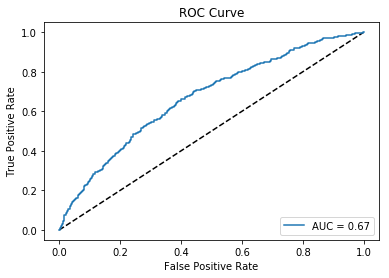

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logit_cv.predict_proba(past_games[training_cols])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(past_games['home_win'], y_pred_prob)

#compute area under the curve
auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Our AUC of .67 is not that great, but I wouldn't really expect anything too high given the difficulty of predicting NFL wins. Remember the default home-win rate is 56%.

In [16]:
# predict the results 
preds=logit_cv.predict(future_games[training_cols])

future_games['prediction'] = preds
future_games['winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['win_prob'] = logit_cv.predict_proba(future_games[training_cols])[:,1]
future_games[['home_team','away_team','winner','win_prob']]

,home_team,away_team,winner,win_prob
1794,BUF,NYJ,BUF,0.719539
1796,CHI,ATL,ATL,0.276296
1797,CIN,BAL,CIN,0.643283
1799,CLE,PIT,PIT,0.391733
1800,DAL,NYG,DAL,0.630312
1802,DET,ARI,ARI,0.460246
1803,GB,SEA,GB,0.646261
1804,HOU,JAC,HOU,0.584420
1808,MIA,TB,TB,0.480326
1809,MIN,NO,MIN,0.575437


# Conclusion

While our model makes perfectly reasonable picks, there is no reason to think that it is superior to just being mildly observant of NFL trends. The most dire limitation of the current model is failure to take into account injury. If New England loses Tom Brady, that could easily knock 10-20 percentage points from the probability of a home win. 

Later in the year we will have more sophisticated models for predicting wins (e.g., support vector machines) as well as models for projecting individual statistics.